<h1 align = "center">Deep Neural Networks, Gradient-Boosted Trees, Random Forests: Statistical Arbitrage on the S&P 500</h1>

### Import Libraries

In [126]:
import pandas as pd
import numpy as np
from datetime import datetime, date, time
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15, 5]
%matplotlib inline

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input,Dense, Dropout, Activation
from keras.initializers import RandomNormal, he_normal
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras import regularizers

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
pd.options.mode.chained_assignment=None

### Retrieval of Data : Prices and Constituents of S&P 500 (WRDS)

In [4]:
main_df = pd.read_sas('C:/Users/Rishabb/Desktop/FALL 19/Stat Arb/Project/Prices_Data_2.sas7bdat')
price_df = main_df.copy()

In [5]:
price_df.head()

,GVKEY,IID,DATADATE,CONM,TIC,PRCCD,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,ccmbegdt
0,b'001013',b'01',1990-01-02,b'ADC TELECOMMUNICATIONS INC',b'ADCT.1',18.625,b'P',b'01',b'LU',50906.0,2902.0,1979-03-16,2010-12-31,1989-02-01
1,b'001013',b'01',1990-01-03,b'ADC TELECOMMUNICATIONS INC',b'ADCT.1',18.500,b'P',b'01',b'LU',50906.0,2902.0,1979-03-16,2010-12-31,1989-02-01
2,b'001013',b'01',1990-01-04,b'ADC TELECOMMUNICATIONS INC',b'ADCT.1',18.125,b'P',b'01',b'LU',50906.0,2902.0,1979-03-16,2010-12-31,1989-02-01
3,b'001013',b'01',1990-01-05,b'ADC TELECOMMUNICATIONS INC',b'ADCT.1',18.250,b'P',b'01',b'LU',50906.0,2902.0,1979-03-16,2010-12-31,1989-02-01
4,b'001013',b'01',1990-01-08,b'ADC TELECOMMUNICATIONS INC',b'ADCT.1',18.000,b'P',b'01',b'LU',50906.0,2902.0,1979-03-16,2010-12-31,1989-02-01


In [6]:
constituent_df = pd.read_excel('C:/Users/Rishabb/Desktop/FALL 19/Stat Arb/Project/Constituent_Data_2.xlsx')

In [7]:
constituent_df = constituent_df[['Start_Date', 'End_Date', 'GVKEY']]

In [8]:
constituent_df['End_Date'] = constituent_df['End_Date'].fillna(date.today())
constituent_df['End_Date'] = pd.to_datetime(constituent_df['End_Date'])
constituent_df['Start_Date'] = pd.to_datetime(constituent_df['Start_Date'])

In [9]:
constituent_df.head()

,Start_Date,End_Date,GVKEY
0,1964-03-31,2019-10-15,1078
1,1964-03-31,2019-10-15,1300
2,1964-03-31,2019-10-15,1440
3,1964-03-31,2019-10-15,2285
4,1964-03-31,2019-10-15,2403


In [10]:
price_df.drop(['IID','TIC','LIID','LINKPRIM','LIID','LINKTYPE','LPERMNO','LPERMCO','LINKDT','LINKENDDT','ccmbegdt'], axis=1, inplace=True)

In [11]:
price_df.rename(columns={'DATADATE':'Date','PRCCD':'Price','CONM':'COMPANY_NAME'}, inplace=True)

In [12]:
price_df['GVKEY'] = price_df['GVKEY'].str.decode('utf-8')
price_df['COMPANY_NAME'] = price_df['COMPANY_NAME'].str.decode('utf-8')

In [13]:
price_df["GVKEY"] = price_df.GVKEY.astype(int)

### Matching the S&P500 Prices and Constituents by their date

In [14]:
loop_1_sdate = pd.to_datetime('1990-01-01')
loop_1_edate = pd.to_datetime('2016-01-01')
tick_list = []
while loop_1_sdate < loop_1_edate:
    temp_date = loop_1_sdate + pd.DateOffset(months = 1)
    temp_df = constituent_df[(constituent_df['Start_Date'] < loop_1_sdate) & (constituent_df['End_Date'] > temp_date)]
    ticker_df = price_df[(price_df['Date'] >= loop_1_sdate) & (price_df['Date'] < temp_date) & (price_df['GVKEY'].isin(temp_df['GVKEY'].values))]
    tick_list.append(ticker_df)
    loop_1_sdate = temp_date  

In [15]:
spx_df = pd.concat(tick_list)

In [16]:
spx_df.sort_values(by=['Date'], inplace=True)

### Creating batches of train(750 trading days) and test(subsequent 250 trading days) list 

In [17]:
loop_1_sdate = pd.to_datetime('1990-01-01')
loop_1_edate = pd.to_datetime('2016-01-01')
train_list = []
test_list = []
dates_list = spx_df.Date.unique()
i = 0
while i < (len(dates_list)-1000):
    temp_date_1 = dates_list[i]
    temp_date_2 = dates_list[i+750]
    temp_date_3 = dates_list[i+1000]
    ticker_df_1 = spx_df[(spx_df['Date'] >= temp_date_1) & (spx_df['Date'] < temp_date_2)]
    ticker_df_2 = spx_df[(spx_df['Date'] >= temp_date_2) & (spx_df['Date'] < temp_date_3)]
    train_list.append(ticker_df_1)
    test_list.append(ticker_df_2)
    i = i+250

In [18]:
len(train_list[0].Date.unique())

750

In [71]:
len(test_list[0].Date.unique())

250

### Feature Engineering 

#### Function to prepare Train data 

In [83]:
def preparation_train_df(X):

### Creation of 31 attributes
    intervals_list = [i for i in range(1,20)] + [j for j in range(20,241,20)]
    temp_list_1 = []
    for ticker, temp_df in X.groupby('GVKEY'):
        if len(temp_df) == 749:
            for i in intervals_list:
                idx = len(temp_df.columns.values)
                temp_df.insert(loc = idx, column="Return_{}".format(i), value=(np.log(temp_df['Price']) - np.log(temp_df['Price'].shift(i))))
            column_list = temp_df.columns.values.tolist()
            column_list.remove('GVKEY')
            column_list.remove('Date')
            column_list.remove('COMPANY_NAME')
            column_list.remove('Price')
            for m in column_list:
                temp_df[m] = temp_df[m].fillna(temp_df[m].mean())
            temp_list_1.append(temp_df)
    pre_process_df = pd.concat(temp_list_1)

### Normalizing train data
    from sklearn import preprocessing
    temp_list_2 = []
    for ticker, temp_df in pre_process_df.groupby('Date'):
        column_list = temp_df.columns.values.tolist()
        column_list.remove('GVKEY')
        column_list.remove('Date')
        column_list.remove('COMPANY_NAME')
        column_list.remove('Price')
        for i in column_list:
            temp_df[i] = (temp_df[i] - temp_df[i].mean())/temp_df[i].std() 
        temp_list_2.append(temp_df)
    pre_process_df_1 = pd.concat(temp_list_2)

### Creation of Conditional column based on our strategy 
    temp_list_3 = []
    for ticker, temp_df in pre_process_df_1.groupby('GVKEY'):
        temp_df = temp_df.assign(Conditional = temp_df.Return_1.shift(-1))
        temp_df['Conditional'] = temp_df['Conditional'].fillna(method = 'ffill')
        colmean = temp_df.Conditional.mean()
        temp_df.Conditional = temp_df.Conditional.apply(lambda x: 1 if x > colmean else 2)    
        temp_list_3.append(temp_df)
    pre_process_df_2 = pd.concat(temp_list_3)

    return pre_process_df_2

#### Function to prepare Test Data

In [82]:
def preparation_test_df(X):
    intervals_list = [i for i in range(1,20)] + [j for j in range(20,241,20)]
    test_list_1 = []
    for ticker, temp_df in X.groupby('GVKEY'):
        if len(temp_df) == 250:
            for i in intervals_list:
                idx = len(temp_df.columns.values)
                temp_df.insert(loc = idx, column="Return_{}".format(i), value=(np.log(temp_df['Price']) - np.log(temp_df['Price'].shift(i))))
            column_list = temp_df.columns.values.tolist()
            column_list.remove('GVKEY')
            column_list.remove('Date')
            column_list.remove('COMPANY_NAME')
            column_list.remove('Price')
            for m in column_list:
                temp_df[m] = temp_df[m].fillna(temp_df[m].mean())
            test_list_1.append(temp_df)
    test_process_df = pd.concat(test_list_1)

    test_list_2 = []
    for ticker, temp_df in test_process_df.groupby('Date'):
        column_list = temp_df.columns.values.tolist()
        column_list.remove('GVKEY')
        column_list.remove('Date')
        column_list.remove('COMPANY_NAME')
        column_list.remove('Price')
        for i in column_list:
            temp_df[i] = (temp_df[i] - temp_df[i].mean())/temp_df[i].std() 
        test_list_2.append(temp_df)
    test_process_df_1 = pd.concat(test_list_2)

    test_list_3 = []
    for ticker, temp_df in test_process_df_1.groupby('GVKEY'):
        temp_df = temp_df.assign(Conditional = temp_df.Return_1.shift(-1))
        temp_df['Conditional'] = temp_df['Conditional'].fillna(method = 'ffill')
        colmean = temp_df.Conditional.mean()
        temp_df.Conditional = temp_df.Conditional.apply(lambda x: 1 if x > colmean else 2)    
        test_list_3.append(temp_df)
    test_process_df_2 = pd.concat(test_list_3)
 
    return test_process_df_2

### Program for first set of Train and Test data 

In [112]:
train_df = preparation_train_df(train_list[0])
test_df = preparation_test_df(test_list[0])

C:\Users\Rishabb\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Rishabb\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Rishabb\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [113]:
train_df.head()

,GVKEY,Date,COMPANY_NAME,Price,Return_1,Return_2,Return_3,Return_4,Return_5,Return_6,...,Return_80,Return_100,Return_120,Return_140,Return_160,Return_180,Return_200,Return_220,Return_240,Conditional
5280,1045,1990-01-02,AMERICAN AIRLINES GROUP INC,59.750,0.186445,0.182242,0.192131,0.181235,0.175203,0.193423,...,0.078169,0.051181,0.061186,0.071964,0.113306,0.182062,0.258761,0.281651,0.301506,2
5281,1045,1990-01-03,AMERICAN AIRLINES GROUP INC,59.500,-0.111304,0.182242,0.192131,0.181235,0.175203,0.193423,...,0.078169,0.051181,0.061186,0.071964,0.113306,0.182062,0.258761,0.281651,0.301506,2
5282,1045,1990-01-04,AMERICAN AIRLINES GROUP INC,58.750,-0.383797,-0.318101,0.192131,0.181235,0.175203,0.193423,...,0.078169,0.051181,0.061186,0.071964,0.113306,0.182062,0.258761,0.281651,0.301506,1
5283,1045,1990-01-05,AMERICAN AIRLINES GROUP INC,59.625,1.432132,0.669719,0.429518,0.181235,0.175203,0.193423,...,0.078169,0.051181,0.061186,0.071964,0.113306,0.182062,0.258761,0.281651,0.301506,2
5284,1045,1990-01-08,AMERICAN AIRLINES GROUP INC,59.125,-0.781588,0.568475,0.185735,0.083169,0.175203,0.193423,...,0.078169,0.051181,0.061186,0.071964,0.113306,0.182062,0.258761,0.281651,0.301506,2


In [114]:
test_df.head()

,GVKEY,Date,COMPANY_NAME,Price,Return_1,Return_2,Return_3,Return_4,Return_5,Return_6,...,Return_80,Return_100,Return_120,Return_140,Return_160,Return_180,Return_200,Return_220,Return_240,Conditional
6029,1045,1992-12-16,AMERICAN AIRLINES GROUP INC,60.625,0.335337,0.286573,0.267005,0.240477,0.209304,0.194836,...,0.220893,0.15274,0.051177,0.097867,0.182623,0.24339,0.213111,0.124836,0.14881,1
6030,1045,1992-12-17,AMERICAN AIRLINES GROUP INC,62.375,1.193347,0.286573,0.267005,0.240477,0.209304,0.194836,...,0.220893,0.15274,0.051177,0.097867,0.182623,0.24339,0.213111,0.124836,0.14881,1
6031,1045,1992-12-18,AMERICAN AIRLINES GROUP INC,63.250,0.086007,0.856743,0.267005,0.240477,0.209304,0.194836,...,0.220893,0.15274,0.051177,0.097867,0.182623,0.24339,0.213111,0.124836,0.14881,1
6032,1045,1992-12-21,AMERICAN AIRLINES GROUP INC,63.750,0.323242,0.327195,0.755980,0.240477,0.209304,0.194836,...,0.220893,0.15274,0.051177,0.097867,0.182623,0.24339,0.213111,0.124836,0.14881,1
6033,1045,1992-12-22,AMERICAN AIRLINES GROUP INC,63.750,0.027146,0.249864,0.265119,0.610199,0.209304,0.194836,...,0.220893,0.15274,0.051177,0.097867,0.182623,0.24339,0.213111,0.124836,0.14881,1


### Objects to track period returns , hit ratios ,conditional expected gain and accuracy of each model 

In [177]:
RAF_long_returns = []
DNN_long_returns = []
GBT_long_returns = []
ENS_long_returns = []

RAF_short_returns = []
DNN_short_returns = []
GBT_short_returns = []
ENS_short_returns = []

RAF_overall_returns = []
DNN_overall_returns = []
GBT_overall_returns = []
ENS_overall_returns = []

RAF_hit_ratio = []
DNN_hit_ratio = []
GBT_hit_ratio = []
ENS_hit_ratio = []

RAF_ceg = []
DNN_ceg = []
GBT_ceg = []
ENS_ceg = []

RAF_accuracy = []
DNN_accuracy = []
GBT_accuracy = []
ENS_accuracy = []

#### List of columns for training models

In [133]:
column_list = train_df.columns.values.tolist()
column_list.remove('GVKEY')
column_list.remove('Date')
column_list.remove('COMPANY_NAME')
column_list.remove('Price')
column_list.remove('Conditional')

### Random Forest Model Run

In [110]:
from sklearn.ensemble import RandomForestClassifier

raf_clf =  RandomForestClassifier(max_depth = 5, n_estimators =  100, random_state = 1)

In [120]:
raf_clf.fit(train_df[column_list],train_df["Conditional"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [121]:
y_pred = raf_clf.predict(test_df[column_list])

In [122]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_df["Conditional"], y_pred, labels=[1, 2])

In [123]:
(conf_mat.T/conf_mat.sum(axis=1)).T

array([[0.57420892, 0.42579108],
       [0.53280577, 0.46719423]])

In [124]:
predprob = raf_clf.predict_proba(test_df[column_list])

In [125]:
predprob

array([[0.51542242, 0.48457758],
       [0.51431626, 0.48568374],
       [0.5091081 , 0.4908919 ],
       ...,
       [0.49284745, 0.50715255],
       [0.48588487, 0.51411513],
       [0.49707238, 0.50292762]])

### Function to evaluate model's strategy performance

In [174]:
from functools import reduce
def evaluate_process(process):
    x,y = process.T

    x = x.tolist()
    y = y.tolist()

    test_df["pred_prob_1"] =  x
    test_df["pred_prob_2"] =  y
    conditions = [(test_df.pred_prob_1 > test_df.pred_prob_2), (test_df.pred_prob_2 > test_df.pred_prob_1)]
    choices = [1,2]
    test_df["prediction"] = np.select(conditions,choices)
    
    list_a = []
    for ticker, temp_df in test_df.groupby('GVKEY'):
        temp_df = temp_df.assign(Return_f1 = temp_df.Return_1.shift(-1))
        temp_df.Return_f1 = temp_df.Return_f1.fillna(method = 'ffill')
        list_a.append(temp_df)
    test_process_df_3 = pd.concat(list_a)

    collection_1Returns = []
    collection_2Returns = []
    ceg_list = []
    hit_ratio = []
    for ticker, temp_df in test_process_df_3.groupby('Date'):
        temp_1 = temp_df.sort_values(by = ["pred_prob_1"], ascending=False)
        temp_2 = temp_df.sort_values(by = ["pred_prob_2"], ascending=False)
        temp_1 = temp_1[:10]
        temp_2 = temp_2[:10]

        df1 = temp_1[['prediction','Conditional']]
        yourdf1 = temp_1[df1.eq(df1.iloc[:, 0], axis=0).all(axis=1)]
        yourdf1.Return_f1 = yourdf1.Return_f1/100 + 1
        hit_ratio.append((len(yourdf1)))
        ceg_list.append(yourdf1.Return_f1.astype(object).product())
        df1 = temp_2[['prediction','Conditional']]
        yourdf1 = temp_2[df1.eq(df1.iloc[:, 0], axis=0).all(axis=1)]
        yourdf1.Return_f1 = 1 - yourdf1.Return_f1/100 
        hit_ratio.append((len(yourdf1)))
        ceg_list.append(yourdf1.Return_f1.astype(object).product())

        arr_1  = temp_1.Return_f1.values
        arr_2  = temp_2.Return_f1.values
        collection_1Returns.append(arr_1)
        collection_2Returns.append(arr_2)

    hit_ratio_num = sum(hit_ratio)/(len(hit_ratio)*10)
    ceg = (reduce(lambda x, y: x * y, ceg_list, 1))**(1/250)

    print("The hit ratio is:",hit_ratio_num)
    print("The conditional expected gain is:",ceg)
    
    returns_1 = 1
    for i in range(len(collection_1Returns)):
        for j in range(len(collection_1Returns[i])):
            returns_1 = returns_1*(1 + (collection_1Returns[i][j]/100))
    print("Long strategy Returns:",returns_1)

    returns_2 = 1
    for i in range(len(collection_2Returns)):
        for j in range(len(collection_2Returns[i])):
            returns_2 = returns_2*(1 - (collection_2Returns[i][j]/100))
    print("Short strategy Returns:",returns_2)

    returns_overall_daily = (returns_1*returns_2)**(1/250)
    print("Overall strategy Returns:",returns_overall_daily)
        
    return returns_1,returns_2,returns_overall_daily,hit_ratio_num,ceg

In [201]:
features = column_list
importances = raf_clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(7,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

NameError: name 'raf_clf' is not defined

In [181]:
a1,a2,a3,a4,a5 = evaluate_process(predprob)

RAF_long_returns.append(a1)
RAF_short_returns.append(a2)
RAF_overall_returns.append(a3)
RAF_hit_ratio.append(a4)
RAF_ceg.append(a5)
RAF_accuracy.append(raf_clf.score(test_df[column_list],test_df.Conditional))

C:\Users\Rishabb\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


The hit ratio is: 0.5682
The conditional expected gain is: 1.1158389327404667
Long strategy Returns: 33.58968814474982
Short strategy Returns: 8.043350709556314
Overall strategy Returns: 1.0226489385315536


### Dense Neural Network (DNN) Model Run

In [29]:
input_dim =  train_df[column_list].shape[1]

In [30]:
hidden = [31,31,10,5] 

n_classes = 2

inputs = Input(shape=(input_dim,), name='inputs')
x = Dropout(0.1)(inputs)
x = Dense(hidden[1], input_dim=input_dim, activation='relu', name='hidden_1')(x)
x = Dropout(0.1)(x)
x = Dense(hidden[2], input_dim=input_dim, activation='relu', name='hidden_2')(x)
x = Dropout(0.1)(x)
x = Dense(hidden[3], input_dim=input_dim, activation='relu', name='hidden_3')(x)
outputs = Dense(n_classes, activation='softmax', name='output')(x)

nn_model = Model(inputs=inputs, outputs=outputs)
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 31)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31)                0         
_________________________________________________________________
hidden_1 (Dense)             (None, 31)                992       
_________________________________________________________________
dropout_2 (Dropout)          (None, 31)                0         
_________________________________________________________________
hidden_2 (Dense)             (None, 10)                320       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
hidden_3 (Dense)             (None, 5)                 55        
__________

In [185]:
x_train = to_categorical(train_df.Conditional.values,3)[:,[1,2]]
y_train = to_categorical(test_df.Conditional.values,3)[:,[1,2]]

In [186]:
nn_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 1000
n_epochs = 10
nn_model_hist = nn_model.fit(train_df[column_list], x_train , batch_size=batch_size, epochs=n_epochs, verbose=1)
val_score = nn_model.evaluate(test_df[column_list], y_train, verbose=0)

print('5-Layer DNN')
print('------------------------')
print('Test loss score: {0:.4f}'.format(val_score[0]))
print('Test accuracy:   {0:.4f}'.format(val_score[1]))

Epoch 1/10
343042/343042 [==============================] - 3s 8us/step - loss: 0.6920 - acc: 0.5177
Epoch 2/10
343042/343042 [==============================] - 2s 6us/step - loss: 0.6920 - acc: 0.5190
Epoch 3/10
343042/343042 [==============================] - 2s 6us/step - loss: 0.6921 - acc: 0.5182
Epoch 4/10
343042/343042 [==============================] - 2s 6us/step - loss: 0.6920 - acc: 0.5196
Epoch 5/10
343042/343042 [==============================] - 2s 6us/step - loss: 0.6920 - acc: 0.5200
Epoch 6/10
343042/343042 [==============================] - 2s 6us/step - loss: 0.6919 - acc: 0.5186
Epoch 7/10
343042/343042 [==============================] - 2s 6us/step - loss: 0.6919 - acc: 0.5196
Epoch 8/10
343042/343042 [==============================] - 2s 6us/step - loss: 0.6920 - acc: 0.5199A: 1s - loss: 0
Epoch 9/10
343042/343042 [==============================] - 2s 6us/step - loss: 0.6919 - acc: 0.5197
Epoch 10/10
343042/343042 [==============================] - 2s 6us/step - l

In [173]:
nn_model_pred = nn_model.predict(test_df[column_list])
nn_model_pred

array([[0.5004082 , 0.49959183],
       [0.50007886, 0.49992108],
       [0.4989575 , 0.5010424 ],
       ...,
       [0.50201684, 0.4979832 ],
       [0.49607712, 0.5039229 ],
       [0.5018612 , 0.49813882]], dtype=float32)

In [187]:
a1,a2,a3,a4,a5 = evaluate_process(nn_model_pred)

DNN_long_returns.append(a1)
DNN_short_returns.append(a2)
DNN_overall_returns.append(a3)
DNN_hit_ratio.append(a4)
DNN_ceg.append(a5)
DNN_accuracy.append(val_score[1])

C:\Users\Rishabb\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


The hit ratio is: 0.5512
The conditional expected gain is: 1.109125003938074
Long strategy Returns: 1.5047593870895373
Short strategy Returns: 0.4845143007412088
Overall strategy Returns: 0.9987368970993886


### Gradient - Boosted Trees Model Run

In [42]:
gbm_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, max_features=15, random_state=1)

In [43]:
gbm_clf.fit(train_df[column_list],train_df["Conditional"])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=15, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)

In [45]:
predictions = gbm_clf.predict(test_df[column_list])
conf_mat = confusion_matrix(test_df["Conditional"], predictions, labels=[1, 2])

In [46]:
(conf_mat.T/conf_mat.sum(axis=1)).T

array([[0.57352102, 0.42647898],
       [0.53589435, 0.46410565]])

In [48]:
class_report = classification_report(test_df["Conditional"], predictions)

In [49]:
print(class_report)

             precision    recall  f1-score   support

          1       0.52      0.57      0.54     59602
          2       0.52      0.46      0.49     59898

avg / total       0.52      0.52      0.52    119500



In [65]:
predprob = gbm_clf.predict_proba(test_df[column_list])

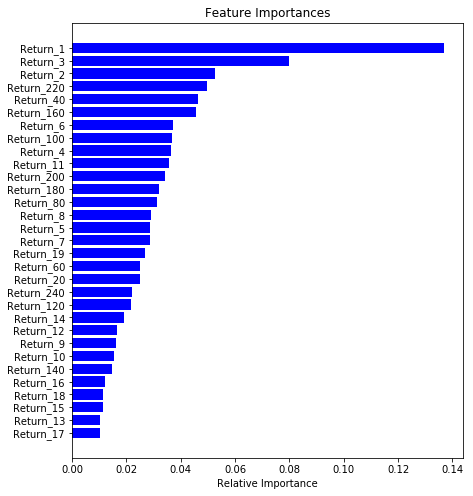

In [222]:
features = column_list
importances = gbm_clf.feature_importances_
indices = np.argsort(importances)

%matplotlib inline

plt.figure(figsize=(7,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [190]:
a1,a2,a3,a4,a5 = evaluate_process(predprob)

GBT_long_returns.append(a1)
GBT_short_returns.append(a2)
GBT_overall_returns.append(a3)
GBT_hit_ratio.append(a4)
GBT_ceg.append(a5)
GBT_accuracy.append(gbm_clf.score(test_df[column_list],test_df.Conditional))

C:\Users\Rishabb\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


The hit ratio is: 0.5682
The conditional expected gain is: 1.1158389327404667
Long strategy Returns: 33.58968814474982
Short strategy Returns: 8.043350709556314
Overall strategy Returns: 1.0226489385315536


### Equally weighted Ensemble of Random Forests and Gradient-Boosted Trees Model Run

In [51]:
eclf = VotingClassifier(estimators=[('rf', raf_clf), ('gbc', gbm_clf)], voting='soft', weights=[1,1])

In [52]:
eclf.fit(train_df[column_list],train_df["Conditional"])

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weigh...         presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=[1, 1])

In [54]:
y_pred = eclf.predict(test_df[column_list])
conf_mat = confusion_matrix(test_df["Conditional"], y_pred, labels=[1, 2])
print((conf_mat.T/conf_mat.sum(axis=1)).T)
class_report = classification_report(test_df["Conditional"], y_pred)
print(class_report)

C:\Users\Rishabb\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[0.57813496 0.42186504]
 [0.53728004 0.46271996]]
             precision    recall  f1-score   support

          1       0.52      0.58      0.55     59602
          2       0.52      0.46      0.49     59898

avg / total       0.52      0.52      0.52    119500



In [67]:
predprob = eclf.predict_proba(test_df[column_list])

In [194]:
a1,a2,a3,a4,a5 = evaluate_process(predprob)

ENS_long_returns.append(a1)
ENS_short_returns.append(a2)
ENS_overall_returns.append(a3)
ENS_hit_ratio.append(a4)
ENS_ceg.append(a5)
ENS_accuracy.append(eclf.score(test_df[column_list],test_df.Conditional))

C:\Users\Rishabb\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


The hit ratio is: 0.5682
The conditional expected gain is: 1.1158389327404667
Long strategy Returns: 33.58968814474982
Short strategy Returns: 8.043350709556314
Overall strategy Returns: 1.0226489385315536


C:\Users\Rishabb\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Running the strategy over more Training periods

In [ ]:
for i in range(1,10):
    train_df = preparation_train_df(train_list[i])
    test_df = preparation_test_df(test_list[i])

    ### Random Forest Run
    raf_clf.fit(train_df[column_list],train_df["Conditional"])
    predprob = raf_clf.predict_proba(test_df[column_list])
    a1,a2,a3,a4,a5 = evaluate_process(predprob)

    RAF_long_returns.append(a1)
    RAF_short_returns.append(a2)
    RAF_overall_returns.append(a3)
    RAF_hit_ratio.append(a4)
    RAF_ceg.append(a5)
    RAF_accuracy.append(raf_clf.score(test_df[column_list],test_df.Conditional))

    ### Dense Neural Network (DNN) Model Run

    x_train = to_categorical(train_df.Conditional.values,3)[:,[1,2]]
    y_train = to_categorical(test_df.Conditional.values,3)[:,[1,2]]

    nn_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    nn_model_hist = nn_model.fit(train_df[column_list], x_train , batch_size=batch_size, epochs=n_epochs, verbose=0)
    val_score = nn_model.evaluate(test_df[column_list], y_train, verbose=0)
    nn_model_pred = nn_model.predict(test_df[column_list])

    a1,a2,a3,a4,a5 = evaluate_process(nn_model_pred)

    DNN_long_returns.append(a1)
    DNN_short_returns.append(a2)
    DNN_overall_returns.append(a3)
    DNN_hit_ratio.append(a4)
    DNN_ceg.append(a5)
    DNN_accuracy.append(val_score[1])

    ### Gradient - Boosted Trees Model Run

    gbm_clf.fit(train_df[column_list],train_df["Conditional"])
    predprob = gbm_clf.predict_proba(test_df[column_list])

    a1,a2,a3,a4,a5 = evaluate_process(predprob)

    GBT_long_returns.append(a1)
    GBT_short_returns.append(a2)
    GBT_overall_returns.append(a3)
    GBT_hit_ratio.append(a4)
    GBT_ceg.append(a5)
    GBT_accuracy.append(gbm_clf.score(test_df[column_list],test_df.Conditional))

    ### Equally weighted Ensemble of Random Forests and Gradient-Boosted Trees Model Run

    eclf = VotingClassifier(estimators=[('rf', classifier_1), ('gbc', gbm_clf)], voting='soft', weights=[1,1])
    eclf.fit(train_df[column_list],train_df["Conditional"])
    predprob = eclf.predict_proba(test_df[column_list])

    a1,a2,a3,a4,a5 = evaluate_process(predprob)

    ENS_long_returns.append(a1)
    ENS_short_returns.append(a2)
    ENS_overall_returns.append(a3)
    ENS_hit_ratio.append(a4)
    ENS_ceg.append(a5)
    ENS_accuracy.append(eclf.score(test_df[column_list],test_df.Conditional))